In [1]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement, combinations
import matplotlib.pyplot as plt
import math

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

首先我對資料有做shuffle，避免資料有按照某種順序做排序，另外我對資料做標準化的動作。

In [2]:
california_housing_dataframe = pd.read_csv("housing.csv")
california_housing_dataframe = (california_housing_dataframe-california_housing_dataframe.mean())/california_housing_dataframe.std()
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

selected_features =  ["total_rooms", "population", "median_income"]
target_features = ["median_house_value"]

training_examples = california_housing_dataframe.head(int(california_housing_dataframe.shape[0]*0.9))
training_x = training_examples[selected_features].values
training_y = training_examples[target_features].values

testing_examples = california_housing_dataframe.tail(int(california_housing_dataframe.shape[0]*0.1))
testing_x = testing_examples[selected_features].values
testing_y = testing_examples[target_features].values

In [3]:
def my_inverse_matrix(matrix):
    dimension = matrix.shape[0]
    diagnoal = np.eye(dimension, dtype=float) 
    
    for d in range(dimension):
        temp = matrix[d][d]
        for c in range(dimension):
            matrix[d][c] = matrix[d][c]/temp
            diagnoal[d][c] = diagnoal[d][c]/temp
        for r in range(dimension):
            mu = -matrix[r][d]
            if r != d:
                for c in range(dimension):
                    matrix[r][c] = matrix[d][c] * mu + matrix[r][c]
                    diagnoal[r][c] = diagnoal[d][c]*mu + diagnoal[r][c]
    return diagnoal

In [4]:
class RegressionModel:
    def __init__(self, M=3, feature_num=3): 
        self.M = M
        self.feature_num = feature_num
    
    def RMSE(self, x, w, t):
        y = np.dot(x, w)
        return math.sqrt(np.mean((y - t) ** 2))
        
    def train(self, x, y, regularize=False, _lambda=1):
        if not regularize:
        # 推導： https://zhuanlan.zhihu.com/p/33899560
        # w = (xT x)^(-1) xT y
            xTx = np.dot(x.T, x)
            tmp = my_inverse_matrix(xTx)
            w = np.dot(np.dot(tmp, x.T), y) 
        else: 
        # 推導： https://blog.csdn.net/coolluyu/article/details/20214617
        # w = (lambdaI + xT x)^(-1) xT y
            xTx = np.dot(x.T, x)
            tmp = my_inverse_matrix(np.eye(xTx.shape[0]) * _lambda + xTx)
            w = np.dot(np.dot(tmp, x.T), y) 
        return w
    
    def preprocess_x(self, x):
        # http://www.csie.ntnu.edu.tw/~u91029/Regression.html#3
        new_x = np.full((len(x), 1), 1)
        
        for order in range(1, self.M+1):
            for comb in list(combinations_with_replacement(range(self.feature_num), order)):
                p = np.expand_dims(np.prod(x[:, comb], axis=1), axis=1)
                new_x = np.concatenate((new_x, p), axis=1)
        return new_x
    

## Problem 3-1  apply the polynomials of order M = 1 to M = 3 over the 3-dimensional input data
1. Evaluate the corresponding Root-Mean-Square error (ERMS = root(2E(w)/N) ) on the Training Set and Test Set 
2. Plot their RMS error versus order M .
3. Describe in details about what you see in the plot.

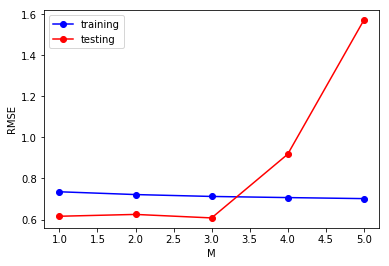

M=1, training error: 0.735338, testing error: 0.616191
M=2, training error: 0.721775, testing error: 0.625101
M=3, training error: 0.712586, testing error: 0.608078
M=4, training error: 0.707082, testing error: 0.918149
M=5, training error: 0.702049, testing error: 1.570390


In [5]:
train_RMSE = []
test_RMSE = []

M_max = 5

for m in range(1, M_max+1):
    RM = RegressionModel(M=m, feature_num=3)
    
    new_training_x = RM.preprocess_x(training_x)
    w = RM.train(new_training_x, training_y)
    _RMSE = RM.RMSE(new_training_x, w, training_y)
    train_RMSE.append(_RMSE)
    
    new_testing_x = RM.preprocess_x(testing_x)
    _RMSE = RM.RMSE(new_testing_x, w, testing_y)
    test_RMSE.append(_RMSE)
    
plt.plot([i for i in range(1, M_max+1)], train_RMSE, '-bo', label='training')
plt.plot([i for i in range(1, M_max+1)], test_RMSE, '-ro', label='testing')

plt.legend(loc='best')
plt.xlabel('M')
plt.ylabel('RMSE')
plt.show()

for i in range(1, M_max+1):
    print("M=%d, training error: %f, testing error: %f" % (i, train_RMSE[i-1], test_RMSE[i-1]))

這個dataset很剛好的在一開始對testing data fit的很好，因為理論上應當training data的RMSE要比testing data來的低，但是在M=4之後明顯誤差值往上飆高，原因是對training data更加的fit以至於對於testing data誤差會更大。而training data的部份呈現不斷遞減。

### Problem 3-2 Select the most contributive attribute or dimension which has the lowest RMS error on the Training Set

In [6]:
for feature_index_comb in list(combinations(range(0, 3), 2)): 
    RM = RegressionModel(M=3, feature_num=len(feature_index_comb))

    new_training_x = RM.preprocess_x(training_x[:, list(feature_index_comb)])
    w = RM.train(new_training_x, training_y)
    _RMSE = RM.RMSE(new_training_x, w, training_y)

    print("Dimension: %d, Attribute_indexes: " % (2), list(feature_index_comb), "\nRMSE: ", _RMSE)
    print()

Dimension: 2, Attribute_indexes:  [0, 1] 
RMSE:  0.9327096193022578

Dimension: 2, Attribute_indexes:  [0, 2] 
RMSE:  0.7270082413880575

Dimension: 2, Attribute_indexes:  [1, 2] 
RMSE:  0.7255938183712136



從三種attribute任選兩個所組合出來的結果，可以看出用total_rooms, population所組合出來的結果誤差值是最高的。
因此可以得知median_income會是最有貢獻的attribute。

### Problem 3-3  Set two values for regularization parameter as λ = 0.1 and λ = 0.001 and repeat part 1
1. RMSE = root(2E(w)/N) is calculated using E(w) not E(w) hat
2. Plot the regularized regression result on Training Set and Testing Set for various order M from 1 to 3. Compare the result with different λ
3. Describe the difference between part 1 and part 3.

M=1, training error: 0.735338, testing error: 0.616192
M=2, training error: 0.721775, testing error: 0.625097
M=3, training error: 0.712586, testing error: 0.608074
M=4, training error: 0.707082, testing error: 0.917825
M=5, training error: 0.702049, testing error: 1.569162


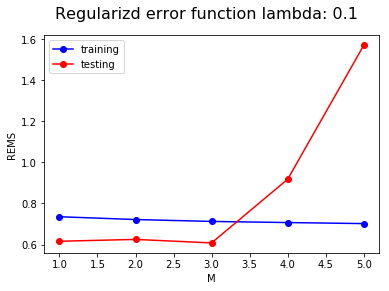

M=1, training error: 0.735338, testing error: 0.616191
M=2, training error: 0.721775, testing error: 0.625101
M=3, training error: 0.712586, testing error: 0.608078
M=4, training error: 0.707082, testing error: 0.918146
M=5, training error: 0.702049, testing error: 1.570378


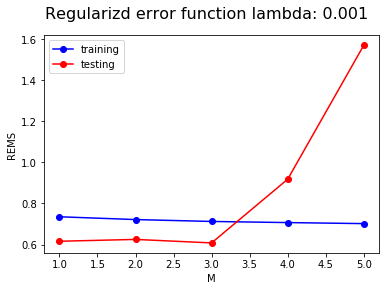

In [7]:
lambdas = [0.1, 0.001] 
M_max = 5

for i, _lambda in enumerate(lambdas):
#     plt.subplot(2, 2, i+1)
    fig = plt.figure()
    title = "Regularizd error function lambda: "+str(_lambda)
    fig.suptitle(title, fontsize=16)
    train_RMSE = []
    test_RMSE = []
    
    for m in range(1, M_max+1):
        RM = RegressionModel(M=m, feature_num=3)

        new_training_x = RM.preprocess_x(training_x)
        w = RM.train(new_training_x, training_y, True, _lambda)
        _RMSE = RM.RMSE(new_training_x, w, training_y)
        train_RMSE.append(_RMSE)

        new_testing_x = RM.preprocess_x(testing_x)
        _RMSE = RM.RMSE(new_testing_x, w, testing_y)
        test_RMSE.append(_RMSE)
    
    for i in range(1, M_max+1):
        print("M=%d, training error: %f, testing error: %f" % (i, train_RMSE[i-1], test_RMSE[i-1]))
    
    plt.plot([i for i in range(1, M_max+1)], train_RMSE, '-bo', label='training')
    plt.plot([i for i in range(1, M_max+1)], test_RMSE, '-ro', label='testing')

    plt.legend(loc='best')
    plt.xlabel('M')
    plt.ylabel('REMS')
    
#     plt.tight_layout()
    plt.show()

Regularized error function的用意是在於為了避免overfit的狀況產生，所以加上懲罰項。
但以M:1~3做訓練，由於誤差值本身很高，所以不存在overfit的問題，因此加上regularize term並不會有顯著的效果。